In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [84]:
import torch
from torch import nn
import torchtext; torchtext.disable_torchtext_deprecation_warning()
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.transforms import Sequential, ToTensor, VocabTransform

from sklearn.model_selection import train_test_split

In [ ]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
# train = pd.read_csv('/kaggle/input/jigsaw-agile-community-rules/train.csv')
# test = pd.read_csv('/kaggle/input/jigsaw-agile-community-rules/test.csv')

In [29]:
train.keys()

Index(['row_id', 'body', 'rule', 'subreddit', 'positive_example_1',
       'positive_example_2', 'negative_example_1', 'negative_example_2',
       'rule_violation'],
      dtype='object')

In [43]:
def extract_examples_data(df):
    example_col = [s for s in df.keys() if 'example' in s]
    example_df = df[example_col].melt(
        value_vars=example_col,
        var_name='col',
        value_name='body'
    )
    example_df['rule_violation'] = 0 if 'neg' in example_df['col'] else 1
    example_df = example_df.drop('col', axis=1)
    return example_df

In [85]:
train_example = extract_examples_data(train)
test_example = extract_examples_data(test)

# combine example dfs with training df
train_data = pd.concat([train[['body', 'rule_violation']], train_example, test_example], axis=0)

# split into training and testing data
train_data, test_data = train_test_split(train_data, test_size=0.2, random_state=42) 

# transform into list of dictionary where each have keys body and rule_violation
train_data = train_data.to_dict(orient='records') 
test_data = test_data.to_dict(orient='records') 

In [86]:
# tokenization and vocabulary
tokenizer = get_tokenizer('basic_english')

def yield_tokens(data):
    for d in data:
        yield tokenizer(d['body'])

# build vocabulary from training data
vocab = build_vocab_from_iterator(yield_tokens(train_data), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

In [87]:
# text transformation: raw text -> tokens -> vocab indeces -> tensor
vocab_transform = VocabTransform(vocab)
to_tensor = ToTensor(padding_value=0)

def text_transform(text):
    tokens = tokenizer(text)
    indices = vocab_transform(tokens)
    return to_tensor(indices)

In [88]:
print(text_transform("This is an example.").shape)

torch.Size([5])


In [90]:
# create datasets and dataloaders
def batching(batch):
    texts, labels=[],[]
    for sample in batch:
        processed_text = torch.tensor(vocab(tokenizer(sample['body'])), dtype=torch.int64)
        texts.append(processed_text)
        labels.append(sample['rule_violation'])

    # pad to equal length
    texts = nn.utils.rnn.pad_sequence(texts, batch_first=True)
    labels = torch.tensor(labels, dtype=torch.float32)
    return texts, labels

# split training data into training and testing data
train_loader = DataLoader(train_data, batch_size=32, collate_fn=batching)
test_loader = DataLoader(test_data, batch_size=32, collate_fn=batching)

In [91]:
# define NN
class RuleClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=64):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.fc1 = nn.Linear(embed_dim, 8)
        self.fc2 = nn.Linear(8, 4)
        self.fc3 = nn.Linear(4, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.embedding(x)
        x = x.mean(dim=1) # mean pooling
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        return self.fc3(x)

In [109]:
# train model
model = RuleClassifier(len(vocab))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50
train_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    try:
        for texts, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        epoch_loss = total_loss / len(train_loader)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch}, Loss: {total_loss:.4f}')
    except Exception as e:
        print('iter error:', e)

Epoch 0, Loss: 167.4918
Epoch 1, Loss: 94.4890
Epoch 2, Loss: 86.1126
Epoch 3, Loss: 82.6754
Epoch 4, Loss: 80.7132
Epoch 5, Loss: 79.8182
Epoch 6, Loss: 78.7325
Epoch 7, Loss: 77.7193
Epoch 8, Loss: 76.3074
Epoch 9, Loss: 75.0154
Epoch 10, Loss: 73.7484
Epoch 11, Loss: 71.3508
Epoch 12, Loss: 69.3178
Epoch 13, Loss: 65.9892
Epoch 14, Loss: 63.6094
Epoch 15, Loss: 61.8838
Epoch 16, Loss: 59.9039
Epoch 17, Loss: 59.3232
Epoch 18, Loss: 58.0346
Epoch 19, Loss: 57.3662
Epoch 20, Loss: 56.6695
Epoch 21, Loss: 55.7967
Epoch 22, Loss: 54.9278
Epoch 23, Loss: 54.8238
Epoch 24, Loss: 53.9952
Epoch 25, Loss: 53.5442
Epoch 26, Loss: 52.7040
Epoch 27, Loss: 52.7614
Epoch 28, Loss: 51.8133
Epoch 29, Loss: 51.7786
Epoch 30, Loss: 51.7005
Epoch 31, Loss: 51.0251
Epoch 32, Loss: 51.0005
Epoch 33, Loss: 50.6331
Epoch 34, Loss: 50.1328
Epoch 35, Loss: 50.5917
Epoch 36, Loss: 49.5901
Epoch 37, Loss: 49.2528
Epoch 38, Loss: 49.7291
Epoch 39, Loss: 49.4504
Epoch 40, Loss: 49.6972
Epoch 41, Loss: 49.4073
E

In [95]:
# evaluation
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for texts, labels in test_loader:
        outputs = model(texts)
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
print(f'Accuracy: {correct / total:.2%}')

Accuracy: 89.59%


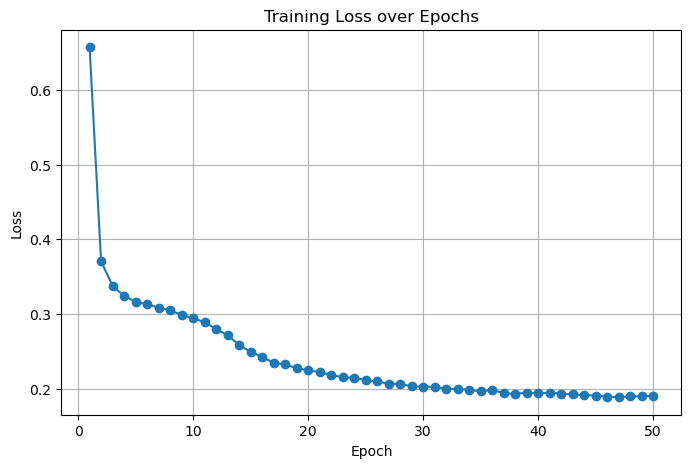

In [111]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [119]:
# make prediction
test_df = test[['body']].to_dict(orient='records') 

In [122]:
# Apply text_transform to each sample
processed_texts = [text_transform(item['body']) for item in test_df]

In [126]:
from torch.nn.utils.rnn import pad_sequence
batch_inputs = pad_sequence(processed_texts, batch_first=True)

In [127]:
model.eval()
with torch.no_grad():
    outputs = model(batch_inputs)
    probs = torch.softmax(outputs, dim=1)
    preds = torch.argmax(probs, dim=1)

In [ ]:
submission = pd.DataFrame({'row_id': test['row_id'], 'rule_violation': preds.numpy()})
submission.to_csv('./submission.csv')
# y_submit.to_csv('/kaggle/working/submission.csv')